# Task 2 Clustering
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to cluster the data

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("../dataset/user_indicators.csv")
df.head(10)

,user_id,lang,bot,created_at,statuses_count,tweet_count,avg_text_len,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,retweet_count_sum,favorite_count_sum
0,2353593986,en,True,2019-02-22 18:00:42,76,127,62.378788,0.037879,0.000000,0.037879,0.098485,0.000000,0.272727,5,5
1,2358850842,en,False,2019-02-26 03:02:32,54,119,68.762295,0.024590,0.000000,0.049180,0.024590,0.000000,0.336066,3,6
2,137959629,en,True,2015-04-30 07:09:56,3,4,19.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,466124818,it,True,2017-01-18 02:49:18,50,1394,86.763030,0.826963,0.000000,0.166782,0.073662,0.022238,0.006254,1190,240
4,2571493866,en,False,2019-06-18 19:30:21,7085,3535,72.214442,0.016958,0.000000,0.056072,0.117888,0.000821,0.505470,62,205
5,2199062688,en,False,2018-11-19 06:58:18,7406,1989,45.100913,393.697261,0.000000,0.735704,0.024027,0.022585,0.928400,819284,1531
6,1174869769,en,True,2018-02-15 10:51:28,21,24,64.041667,630.166667,0.000000,94.666667,0.458333,0.125000,0.125000,15124,2272
7,3118659848,en,False,2020-03-31 21:19:59,115,130,62.400000,3090.303704,0.000000,0.925926,0.111111,0.088889,0.807407,417191,125
8,616225564,en,False,2017-06-25 15:49:36,2041,58,66.883333,69.850000,0.016667,0.050000,0.233333,0.033333,0.016667,4191,3
9,2357425536,en,True,2019-02-25 04:30:56,69,144,64.286667,0.040000,0.000000,0.033333,0.100000,0.000000,0.340000,6,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             11508 non-null  int64  
 1   lang                11508 non-null  object 
 2   bot                 11508 non-null  bool   
 3   created_at          11508 non-null  object 
 4   statuses_count      11508 non-null  int64  
 5   tweet_count         11508 non-null  int64  
 6   avg_text_len        11508 non-null  float64
 7   retweet_count_avg   11508 non-null  float64
 8   reply_count_avg     11508 non-null  float64
 9   favorite_count_avg  11508 non-null  float64
 10  num_hashtags_avg    11508 non-null  float64
 11  num_urls_avg        11508 non-null  float64
 12  num_mentions_avg    11508 non-null  float64
 13  retweet_count_sum   11508 non-null  int64  
 14  favorite_count_sum  11508 non-null  int64  
dtypes: bool(1), float64(7), int64(5), object(2)
memory us

In [4]:
cat_feature = df[['user_id', 'lang', 'created_at']]
del df['user_id']
del df['lang']
del df['created_at']
del df['bot']
df.head()

,statuses_count,tweet_count,avg_text_len,retweet_count_avg,reply_count_avg,favorite_count_avg,num_hashtags_avg,num_urls_avg,num_mentions_avg,retweet_count_sum,favorite_count_sum
0,76,127,62.378788,0.037879,0.0,0.037879,0.098485,0.000000,0.272727,5,5
1,54,119,68.762295,0.024590,0.0,0.049180,0.024590,0.000000,0.336066,3,6
2,3,4,19.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0
3,50,1394,86.763030,0.826963,0.0,0.166782,0.073662,0.022238,0.006254,1190,240
4,7085,3535,72.214442,0.016958,0.0,0.056072,0.117888,0.000821,0.505470,62,205


## Clustering Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(df.values)
X

array([[-0.30258956, -0.66364966, -0.34704183, ..., -0.2293346 ,
        -0.17600845, -0.07752062],
       [-0.30376279, -0.67015003,  0.04770931, ..., -0.05664378,
        -0.1760091 , -0.07748064],
       [-0.30648253, -0.76359287, -3.0140927 , ..., -0.97292096,
        -0.17601008, -0.07772051],
       ...,
       [-0.30632254, -0.76115523,  0.25676065, ...,  0.19557188,
        -0.17601008, -0.07772051],
       [-0.30440273, -0.68477587, -0.32452807, ...,  0.01380633,
        -0.17600779, -0.07740068],
       [-0.0251226 ,  2.11607153, -0.98720074, ...,  1.19040404,
         0.48220648, -0.06028945]])

In [5]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df.values)
X

AttributeError: 'numpy.ndarray' object has no attribute 'head'

## K-MEANS

In [9]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()

    for numCluster in n_clusters_list:

        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [16]:
clusters_list = [x for x in range(1, 30)]
init_value = 10
iter_value = 300

kmeans_list = KMeansFunction (X, clusters_list, init_value, iter_value)

sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print('K:', clusters_list[i], ' - SSE:', kmeans.inertia_)

K: 1  - SSE: 126587.99999999994
K: 2  - SSE: 109350.46011975067
K: 3  - SSE: 93864.25911966056
K: 4  - SSE: 82820.97755792699
K: 5  - SSE: 73605.68047426576
K: 6  - SSE: 65000.46478613172
K: 7  - SSE: 58080.238609075874
K: 8  - SSE: 48683.68110322411
K: 9  - SSE: 43271.51622535024
K: 10  - SSE: 38214.11859108176
K: 11  - SSE: 35191.932833806706
K: 12  - SSE: 32631.207458597255
K: 13  - SSE: 30781.33201609966
K: 14  - SSE: 28898.568913084113
K: 15  - SSE: 27083.412598431943
K: 16  - SSE: 25601.25071568658
K: 17  - SSE: 24670.149562347895
K: 18  - SSE: 23385.15750806781
K: 19  - SSE: 22503.961352442202
K: 20  - SSE: 21603.96285156209
K: 21  - SSE: 20893.422721419392
K: 22  - SSE: 20135.11977605774
K: 23  - SSE: 19377.68886072613
K: 24  - SSE: 18602.24001002511
K: 25  - SSE: 18154.251973100043
K: 26  - SSE: 17506.118838708553
K: 27  - SSE: 17063.030807724193
K: 28  - SSE: 16553.75960960263
K: 29  - SSE: 15939.063613855778


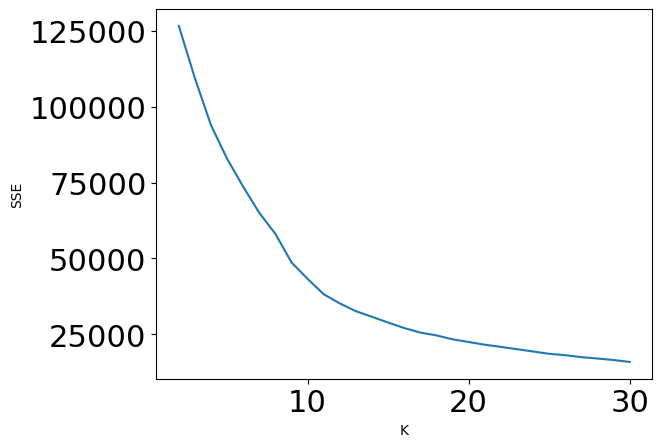

In [17]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

Scegliere k adeguato

scatter con plot adeguato

# DBSCAN

In [21]:
def db_scan_function (X, eps_list, minpts_list, max_iter_value=300):
    dbscan_table = list()

    for i, eps in enumerate(eps_list):
        dbscan_table.append([]) 

        for minpts in minpts_list:
            dbscan = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
            dbscan.fit(X)
            dbscan_table[i].append(dbscan)
    
    return dbscan_table

In [23]:
eps_list = [0.01, 0.05, 0.1, 0.5, 1, 5]
minpts_list = [2, 3, 5, 5]

dbscan_table = db_scan_function(X, eps_list, minpts_list)

In [24]:
sse_list = []
for i, eps in enumerate(eps_list):
    for j, minpts  in enumerate(minpts_list):
        dbscan = dbscan_table[i][j]
        sse_list.append(dbscan.inertia_)
        print('eps:', eps, 'minpts:', minpts ,' - SSE:', dbscan.inertia_)

AttributeError: 'DBSCAN' object has no attribute 'inertia_'